### Import thư viện

In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from PIL import Image

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [4]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf

---

### Đọc dữ liệu

In [5]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../../data/train/Fish_Dataset'
MASK_PATH = '../../data/train/Fish_Dataset_GT'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [6]:
def read_image(path, color = True, label=True):
    data = [] # mảng chứa dữ liệu
    folders = os.listdir(path)
    for folder in folders:
        folder_path = os.path.join(path, folder)
        for i in range(1, 1001):
            img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

            img = cv2.imread(img_path)
            if color == True:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            img = cv2.resize(img, (128, 128))
            if label == True:
                data.append([img, folder])
            else:
                data.append(img)
    return data

In [ ]:
data = read_image(TRAIN_PATH)
masks = read_image(MASK_PATH, color= False, label= False)

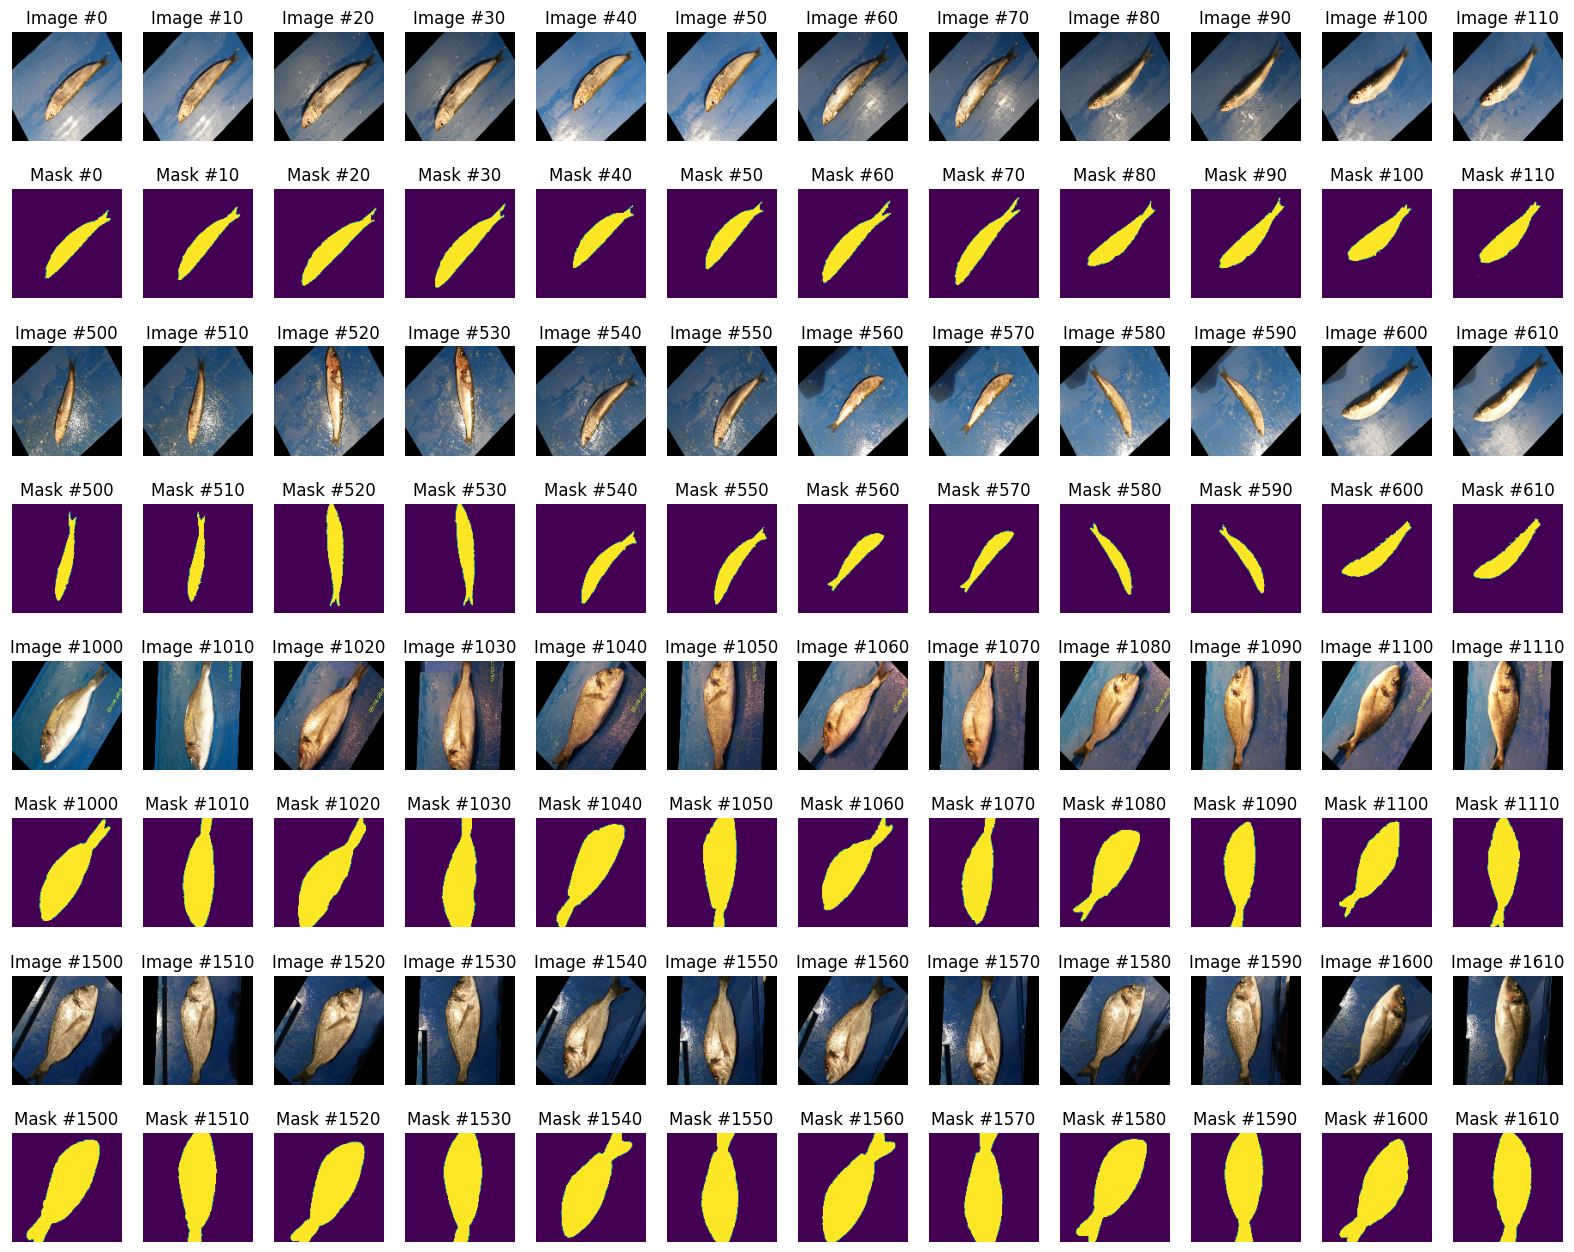

In [9]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*500 + j*10
        plt.imshow(data[pos][0])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(masks[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [10]:
images = []
names = []

for image, name in data:
    images.append(image)
    names.append(name)

In [11]:
# chuấn hóa label thành dạng số
le = LabelEncoder()
names = le.fit_transform(names)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [12]:
images = np.array(images)
masks = np.array(masks)

In [13]:
masks = masks.reshape(9000, 128, 128, 1)

In [14]:
masks = masks.astype(bool)

In [15]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, stratify=names)

train_images.shape, val_images.shape, train_masks.shape, val_masks.shape

((7200, 128, 128, 3),
 (1800, 128, 128, 3),
 (7200, 128, 128, 1),
 (1800, 128, 128, 1))

---

### Xây dựng mô hình

In [18]:
# Tính chỉ số IoU (Intersection over Union) và áp dụng để đánh giá mô hình.
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    #  Chuẩn bị dữ liệu để tính toán union (tổng hợp) giữa các đối tượng
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Tính union
    union = area_true + area_pred - intersection

    # Lọc bỏ nền
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Tính toán chỉ số iou
    iou = intersection / union
    # tính toán các tp,fp,fn dựa trên ngưỡng và iou
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # đối tượng đúng
        false_positives = np.sum(matches, axis=0) == 0  # đối tượng bị khuyết thiếu
        false_negatives = np.sum(matches, axis=1) == 0  # đối tượng phụ
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    #Tính toán các giá trị precision (độ chính xác) tương ứng với từng ngưỡng (threshold) IoU (Intersection over Union) thông qua vòng lặp for:
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)


# Tính trung bình các iou trên từng mẫu 
def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

# Đánh giá mô hình  trả về giá trị số thực
def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [ ]:
tf.config.run_functions_eagerly(False) 

# Cấu trúc mạng unet

In [ ]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2,2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2,2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2,2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D((2,2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same") (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same") (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same") (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same") (c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1,1), activation='sigmoid') (c9)

In [ ]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[my_iou_metric])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
tf.compat.v1.disable_eager_execution()

model_path = "../model/unet.keras"

checkpoint = ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=1, restore_best_weights=True)

results = model.fit(train_images, train_masks, validation_split=0.1, batch_size=16, epochs=10, callbacks=[earlystop, checkpoint])

Train on 6480 samples, validate on 720 samples
Epoch 1/10
6480/6480 [==============================] - ETA: 0s - loss: 0.0864 - my_iou_metric: 0.5789

c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.04540, saving model to unet_1.hdf5
6480/6480 [==============================] - 540s 83ms/sample - loss: 0.0864 - my_iou_metric: 0.5789 - val_loss: 0.0454 - val_my_iou_metric: 0.8008
Epoch 2/10
6480/6480 [==============================] - ETA: 0s - loss: 0.0557 - my_iou_metric: 0.7254
Epoch 2: val_loss improved from 0.04540 to 0.04506, saving model to unet_1.hdf5
6480/6480 [==============================] - 539s 83ms/sample - loss: 0.0557 - my_iou_metric: 0.7254 - val_loss: 0.0451 - val_my_iou_metric: 0.8117
Epoch 3/10
6480/6480 [==============================] - ETA: 0s - loss: 0.0473 - my_iou_metric: 0.7957
Epoch 3: val_loss improved from 0.04506 to 0.03873, saving model to unet_1.hdf5
6480/6480 [==============================] - 536s 83ms/sample - loss: 0.0473 - my_iou_metric: 0.7957 - val_loss: 0.0387 - val_my_iou_metric: 0.8171
Epoch 4/10
6480/6480 [==============================] - ETA: 0s - loss: 0.0463 - my_iou_metric: 0.7924
Epoch 4: v

---

### Load Model

In [19]:
model = load_model("../model/unet.hdf5", 
                   custom_objects={'my_iou_metric': my_iou_metric})

In [ ]:
preds_train = model.predict(train_images[:int(train_images.shape[0]*0.9)], verbose=1)

203/203 [==============================] - 116s 568ms/step


In [ ]:
preds_val = model.predict(val_images, verbose=1)

57/57 [==============================] - 32s 558ms/step


In [ ]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

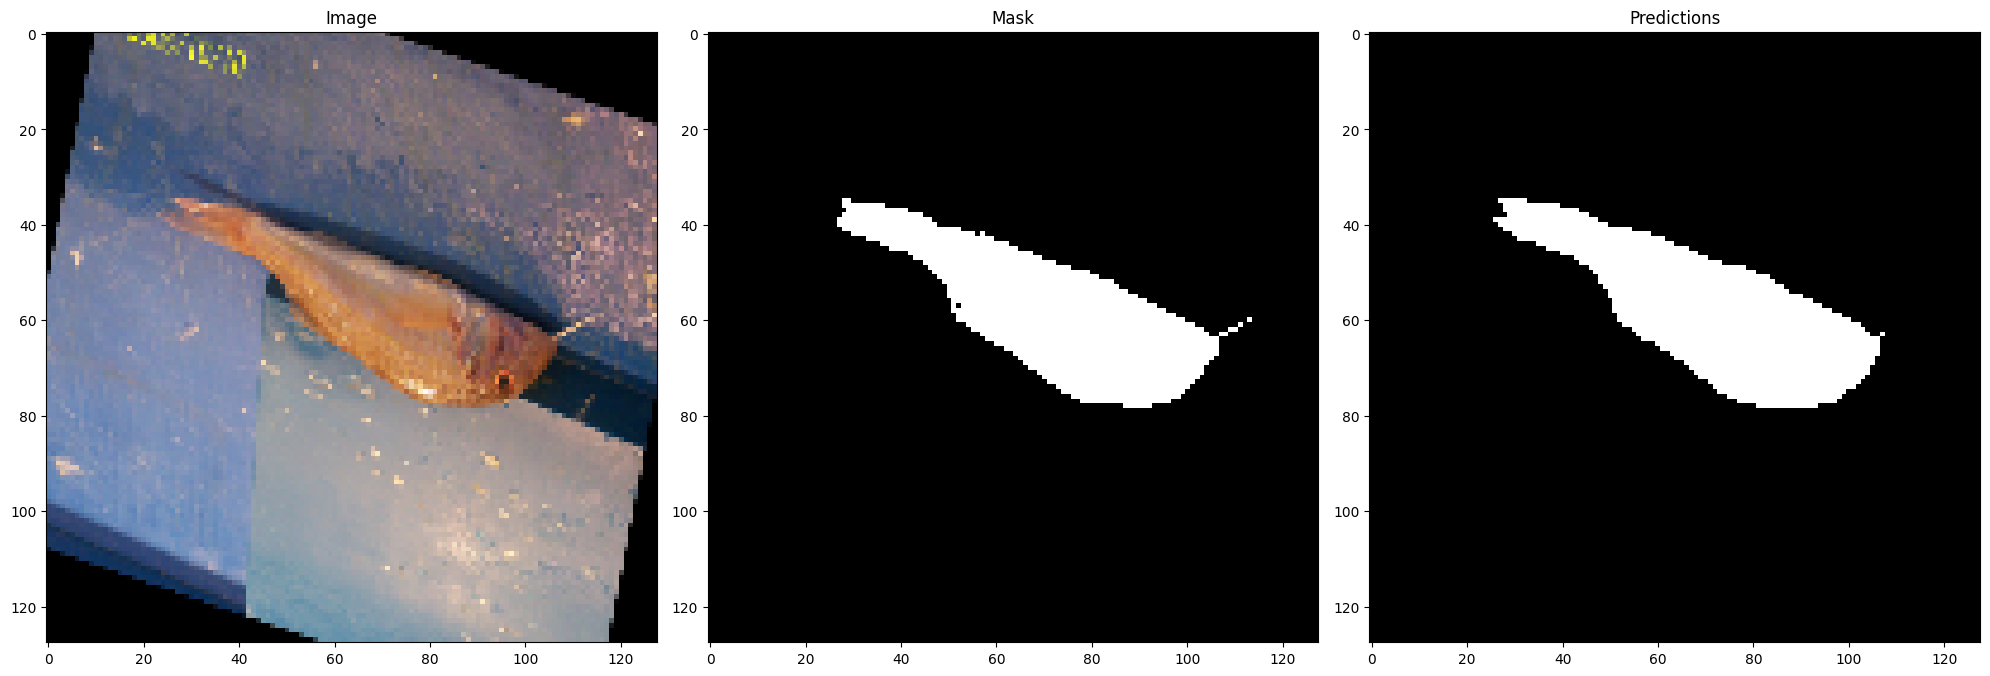

In [ ]:
# Hiển thị ảnh 
ix = random.randint(0, 800)
plt.figure(figsize=(20,20))

# hiển thị ảnh gốc
plt.subplot(131)
imshow(train_images[ix])
plt.title("Image")

# hiển thị mask  
plt.subplot(132)
imshow(np.squeeze(train_masks[ix]))
plt.title("Mask")

# hiện thị mask do mạng unet dự đoán
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

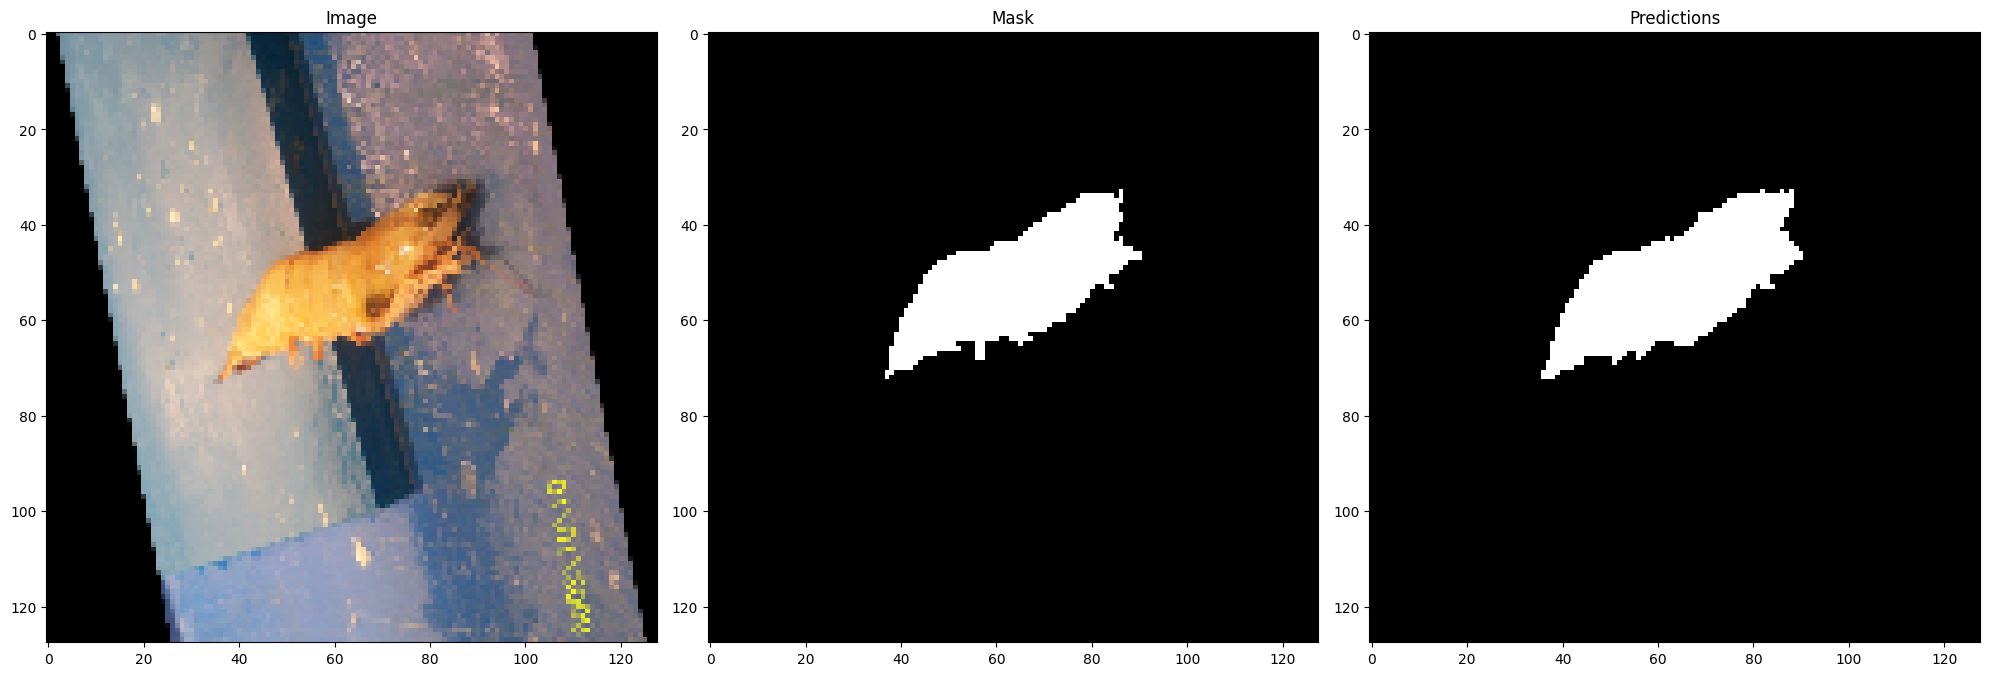

In [ ]:
# Hiển thị ảnh
ix = random.randint(0, 1800)
plt.figure(figsize=(20,20))

# hiển thị ảnh gốc
plt.subplot(131)
imshow(val_images[ix])
plt.title("Image")

#  hiển thị mask  
plt.subplot(132)
imshow(np.squeeze(val_masks[ix]))
plt.title("Mask")

# hiển thị mask do mạng unet dự đoán
plt.subplot(133)
imshow(np.squeeze(preds_val_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

In [ ]:
test = images[5975].reshape(1, 128, 128, 3)

In [ ]:
preds_val = model.predict(test, verbose=1)

1/1 [==============================] - 0s 60ms/step


In [ ]:
preds_val_t = (preds_val > 0.5).astype(np.uint8)

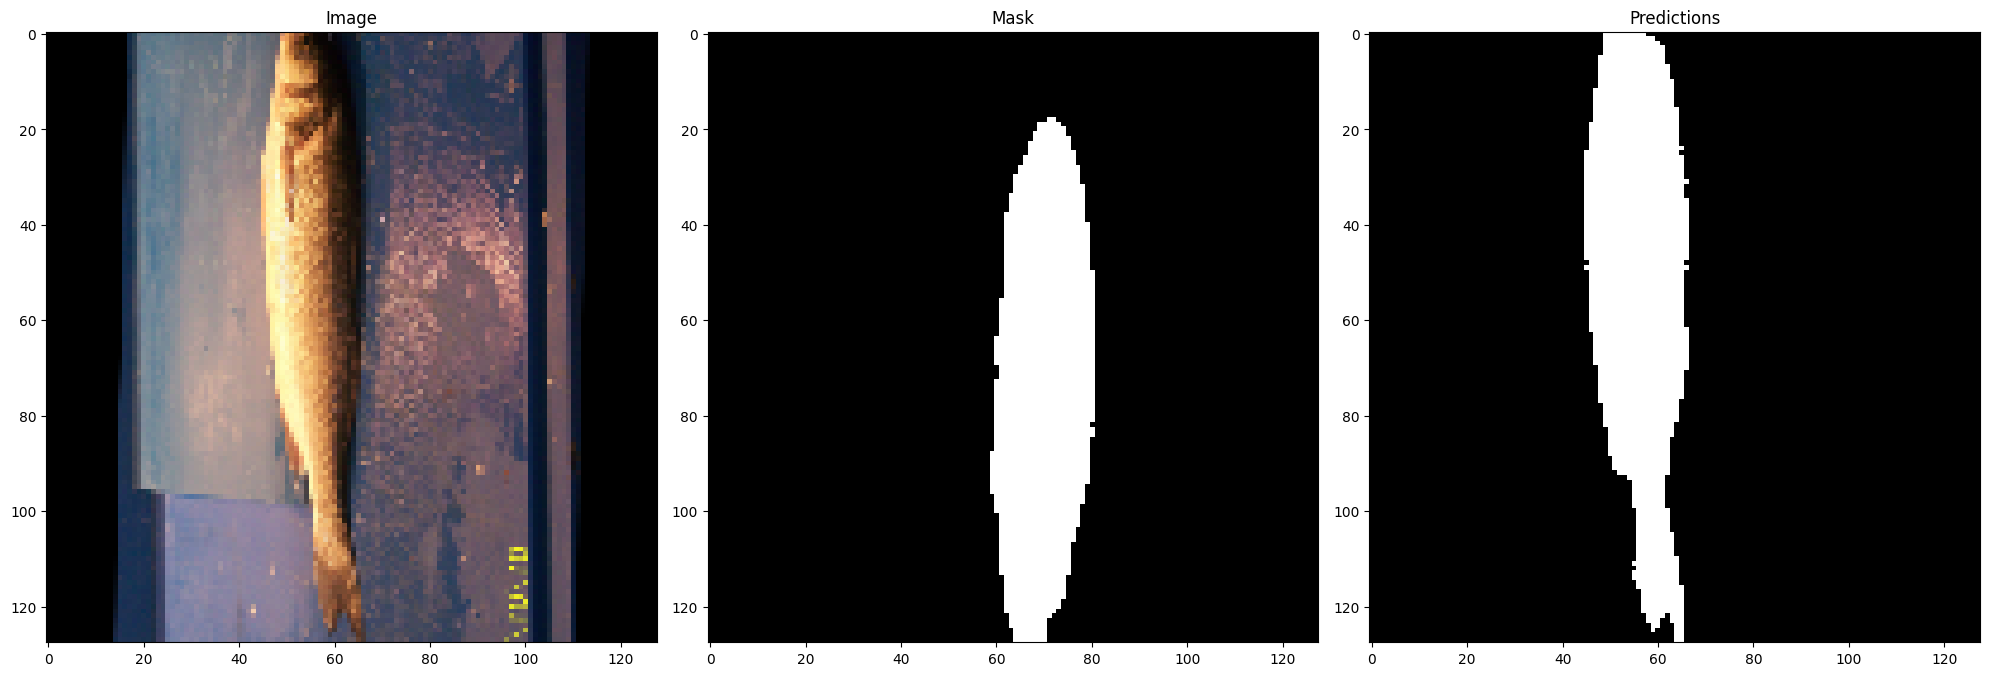

In [ ]:
plt.figure(figsize=(20,20))
# hiển thị ảnh gốc
plt.subplot(131)
imshow(images[5975])
plt.title("Image")

# hiển thị mask
plt.subplot(132)
imshow(np.squeeze(masks[5975]))
plt.title("Mask")

# hiển thị mask do mạng unet dự đoán
plt.subplot(133)
imshow(np.squeeze(preds_val_t > 0.5))
plt.title("Predictions")
plt.show()

---

### Lưu ảnh GT

In [ ]:
img_gt = model.predict(images, verbose=1)

282/282 [==============================] - 162s 577ms/step


In [ ]:
img_gt = (img_gt > 0.5).astype(np.uint8)

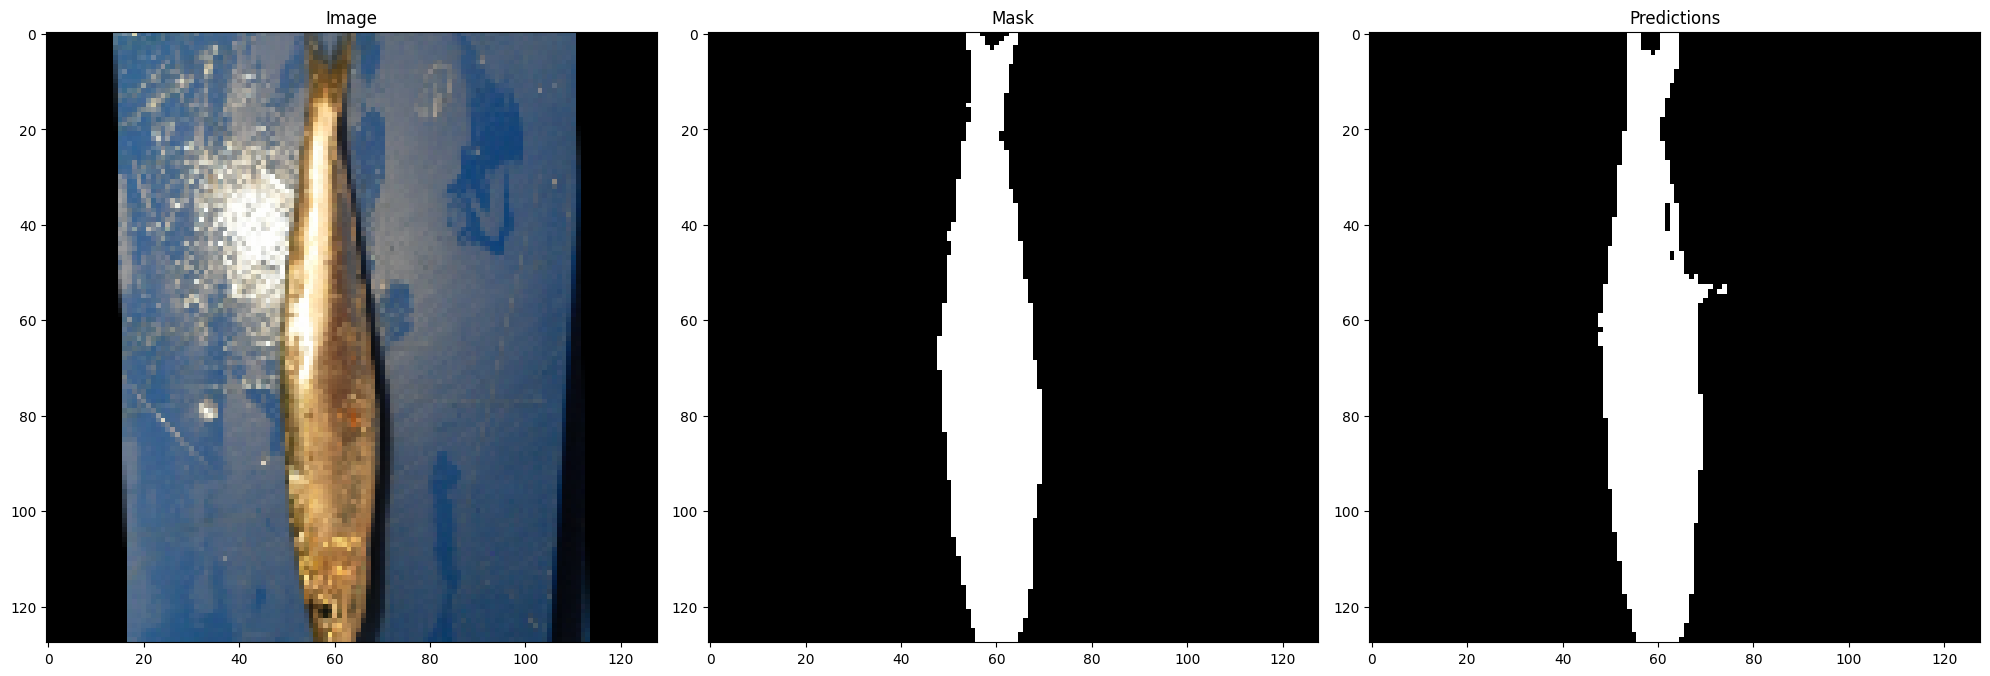

In [ ]:
# Hiển thị ảnh
ix = random.randint(0, 9000)
plt.figure(figsize=(20,20))

#Hiển thị ảnh gốc
plt.subplot(131)
imshow(images[ix])
plt.title("Image")

# Hiển thị mask  
plt.subplot(132)
imshow(np.squeeze(masks[ix]))
plt.title("Mask")

# Hiển thị mask do mạng unet dự đoán
plt.subplot(133)
imshow(np.squeeze(img_gt[ix] > 0.5))
plt.title("Predictions")
plt.show()

In [ ]:
output_folder = '../../data/train/Fish_Dataset_GT'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
# Xác định tên thư mục
folder_names = ['Black Sea Sprat', 'Gilt Head Bream', 'Hourse Mackerel', 'Red Mullet',
               'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

# Tạo thư mục nếu nó chưa tồn tại
for folder_name in folder_names:
    folder_path = os.path.join(output_folder, folder_name)
    os.makedirs(folder_path, exist_ok=True)

In [ ]:
# Giảm chiều băng cách loại bỏ các chiều là 1
img_gt = np.squeeze(img_gt)

In [ ]:
# Lặp qua các hình ảnh
for i in range(len(img_gt)):
    # Lấy tên thư mục và chỉ mục ảnh
    folder_index = i // 1000
    folder_name = folder_names[folder_index]
    image_index = i % 1000

  # Định dạng chỉ mục ảnh dưới dạng chuỗi 5 chữ số
    image_index_str = str(image_index + 1).zfill(5)

    # Tạo tên ảnh
    filename = f'{image_index_str}.png'

    # Chuyển đổi về dạng nhị phân
    img_binary = (img_gt[i] > 0.5).astype(np.uint8) * 255

    # Tạo đối tượng từ mảng nhị phân
    pred_image = Image.fromarray(img_binary, mode='L')

    # Lưu các ảnh
    folder_path = os.path.join(output_folder, folder_name)
    output_path = os.path.join(folder_path, filename)
    pred_image.save(output_path)